In [1]:
import os
import pandas as pd
from project.input.resources import resources_data
from project.model import get_inputs
from project.utils import cumulated_plot, cumulated_plots, plot_attribute, subplots_attributes, subplots_pie, reindex_mi
from project.building import AgentBuildings


- General description
- Annual consumption
- thermal resistence
- cost curves and mac curves

In [2]:
path = 'output/static'
if not os.path.isdir(path):
    os.mkdir(path)

inputs = get_inputs(path)
buildings = inputs['buildings']


2022-11-25 10:20:22,575 - 7133 - log_static - INFO - Creating AgentBuildings object


In [3]:
'''profeel = pd.read_csv('building_stock_profeel_detailed.csv', index_col=['Class', 'Housing type', 'Wall', 'Floor', 'Roof', 'Windows'])
profeel = profeel[profeel['Heating system'] != 'RCU']'''

"profeel = pd.read_csv('building_stock_profeel_detailed.csv', index_col=['Class', 'Housing type', 'Wall', 'Floor', 'Roof', 'Windows'])\nprofeel = profeel[profeel['Heating system'] != 'RCU']"

In [4]:
inputs = get_inputs(building_stock='project/input/stock/building_stock_profeel_final.csv')
profeel = inputs['buildings']

2022-11-25 10:20:24,432 - 7133 - log_ - INFO - Creating AgentBuildings object


## General stock description

In [5]:
stock = profeel.simplified_stock(energy_level=True)

stock


Occupancy status  Income owner  Income tenant  Housing type   Heating system                  Energy       Performance
Owner-occupied    D1            D1             Multi-family   Electricity-Performance boiler  Electricity  D              64591.036610
                                                                                                           E               9785.626702
                                                                                                           G              41840.860759
                                                              Natural gas-Standard boiler     Natural gas  C               1796.548661
                                                                                                           D               7623.223411
                                                                                                                              ...     
Social-housing    D10           D9             Single-family  Natural g

In [6]:
stock = stock.groupby(
    ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Energy', 'Performance']).sum()


KeyError: "['Oil fuel'] not in index"

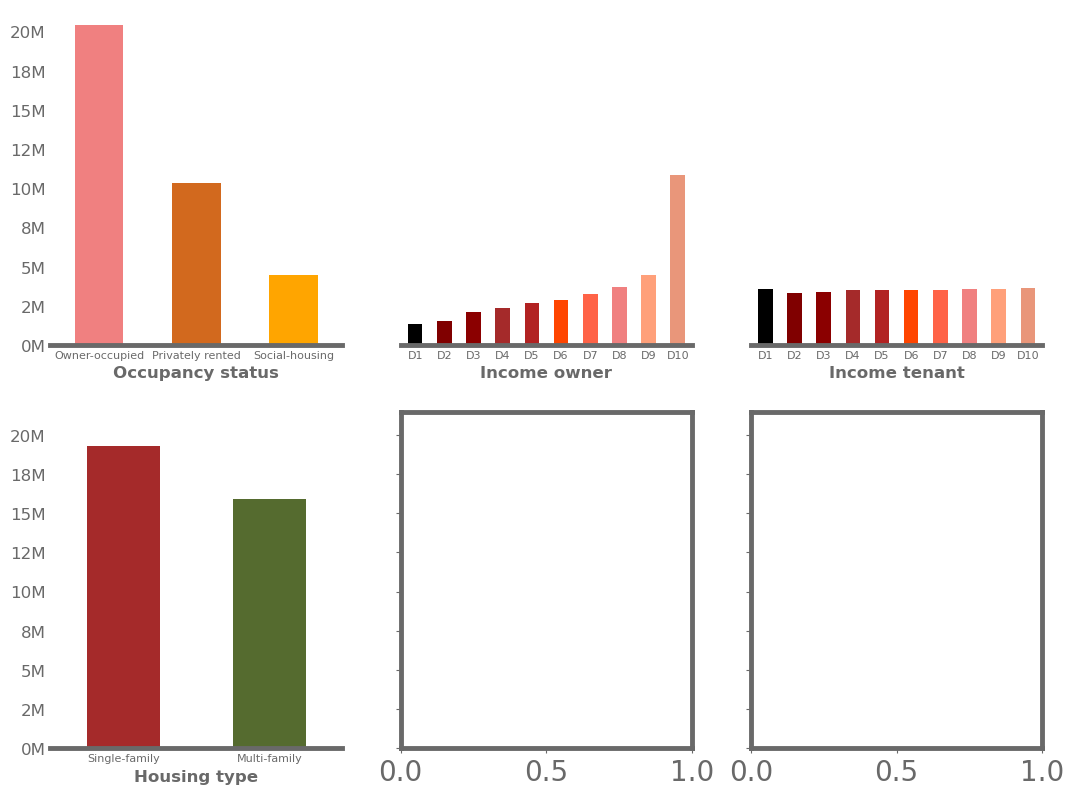

In [7]:
subplots_attributes(stock, dict_order=resources_data['index'], dict_color=resources_data['colors'], percent=False,
                    sharey=True)
subplots_attributes(stock, dict_order=resources_data['index'], dict_color=resources_data['colors'], percent=False,
                    sharey=True, save='output')

In [ ]:
subplots_pie(stock, dict_order=resources_data['index'], pie=['Housing type', 'Energy', 'Occupancy status'], dict_color=resources_data['colors'], percent=False)

## Thermal transmittance description

In [ ]:
temp = dict()
for i in ['Wall', 'Floor', 'Roof', 'Windows']:
    y = pd.Series(profeel.stock.index.get_level_values(i), index=profeel.stock.index,
               name='{} insulation (W/m2.K)'.format(i)).astype('float')
    x = profeel.stock / 10 ** 6
    temp.update({i: cumulated_plot(x, y, plot=False)})

cumulated_plots(temp, 'Thermal transmittance U (W/m2.K)', ylim=3)

In [ ]:
temp = dict()
for i in ['Wall', 'Floor', 'Roof', 'Windows']:
    y = pd.Series(buildings.stock.index.get_level_values(i), index=buildings.stock.index,
                  name='{} insulation (W/m2.K)'.format(i)).astype('float')
    x = buildings.stock / 10 ** 6
    temp.update({i: cumulated_plot(x, y, plot=False)})

cumulated_plots(temp, 'Thermal transmittance U (W/m2.K)', ylim=3)

Comment the comparison:


# Marginal abatement cost curves

##### Selecting one gesture by segments

In [ ]:
insulation = {'Wall': (True, False, False, False), 'Floor': (False, True, False, False), 'Roof': (False, False, True, False), 'Windows': (False, False, False, True), 'Global': (True, True, True, True)}

In [ ]:
energy_prices = inputs['energy_prices']
cost_insulation = inputs['cost_insulation']
carbon_emission = inputs['carbon_emission']
carbon_value_kwh = inputs['carbon_value_kwh']
health_cost = inputs['health_cost']



##### Hummels method

In [ ]:
    def mitigation_potential(self, prices, cost_insulation_raw, carbon_emission=None, carbon_value=None, health_cost=None,
                             index=None):
        """Function returns bill saved and cost for buildings stock retrofit.

        Not implemented yet but should be able to calculate private and social indicator.
        Make cost abatement cost graphs, payback period graphs.

        Parameters
        ----------
        index
        prices
        cost_insulation_raw
        carbon_emission
        carbon_value
        health_cost

        Returns
        -------

        """

        output = dict()

        if index is None:
            index = self.stock.index

        consumption_before = self.consumption_standard(index)[0]
        consumption_after, _, certificate_after = self.prepare_consumption(self._choice_insulation, index=index)
        consumption_saved = (consumption_before - consumption_after.T).T

        self._efficiency.index.names = ['Heating system']
        efficiency = reindex_mi(self._efficiency, consumption_before.index)
        need_before = consumption_before * efficiency

        consumption_before = reindex_mi(consumption_before, index)
        need_before = reindex_mi(need_before, index)
        consumption_after = reindex_mi(consumption_after, index)
        consumption_saved = reindex_mi(consumption_saved, index)
        efficiency = reindex_mi(self._efficiency, consumption_saved.index)
        need_saved = (consumption_saved.T * efficiency).T

        consumption_actual_before = self.consumption_actual(prices.loc[self.year, :], consumption_before)
        consumption_actual_after = self.consumption_actual(prices.loc[self.year, :], consumption_after)
        consumption_actual_saved = (consumption_actual_before - consumption_actual_after.T).T

        consumption_before = reindex_mi(self._surface, index) * consumption_before
        consumption_after = (reindex_mi(self._surface, index) * consumption_after.T).T
        consumption_saved = (reindex_mi(self._surface, index) * consumption_saved.T).T

        need_before = reindex_mi(self._surface, index) * need_before
        need_saved = (reindex_mi(self._surface, index) * need_saved.T).T

        consumption_actual_before = (reindex_mi(self._surface, index) * consumption_actual_before.T).T
        consumption_actual_after = (reindex_mi(self._surface, index) * consumption_actual_after.T).T
        consumption_actual_saved = (reindex_mi(self._surface, index) * consumption_actual_saved.T).T

        output.update({'Stock (dwellings/segment)': self.stock,
                       'Surface (m2/segment)': self.stock * reindex_mi(self._surface, index),
                       'Consumption before (kWh/dwelling)': consumption_before,
                       'Consumption before (kWh/segment)': consumption_before * self.stock,
                       'Need before (kWh/segment)': need_before * self.stock,
                       'Consumption actual before (kWh/dwelling)': consumption_actual_before,
                       'Consumption actual before (kWh/segment)': consumption_actual_before * self.stock,
                       'Consumption actual after (kWh/dwelling)': consumption_actual_after,
                       'Consumption actual after (kWh/segment)': (consumption_actual_after.T * self.stock).T,
                       'Consumption saved (kWh/dwelling)': consumption_saved,
                       'Consumption saved (kWh/segment)': (consumption_saved.T * self.stock).T,
                       'Need saved (kWh/segment)': (need_saved.T * self.stock).T,
                       'Consumption actual saved (kWh/dwelling)': consumption_actual_saved,
                       'Consumption actual saved (kWh/segment)': (consumption_actual_saved.T * self.stock).T
                       })

        consumption_saved_agg = (self.stock * consumption_saved.T).T
        consumption_actual_saved_agg = (self.stock * consumption_actual_saved.T).T

        if carbon_emission is not None:
            c = self.add_energy(consumption_actual_before)
            emission_before = reindex_mi(carbon_emission.T.rename_axis('Energy', axis=0), c.index).loc[:,
                              self.year] * c

            c = self.add_energy(consumption_actual_after)
            emission_after = (reindex_mi(carbon_emission.T.rename_axis('Energy', axis=0), c.index).loc[:,
                              self.year] * c.T).T

            emission_saved = - emission_after.sub(emission_before, axis=0).dropna()

            output.update({'Emission before (gCO2/dwelling)': emission_before,
                           'Emission after (gCO2/dwelling)': emission_after,
                           'Emission saved (gCO2/dwelling)': emission_saved,
                           })

            if carbon_value is not None:
                c = self.add_energy(consumption_actual_before)
                emission_value_before = reindex_mi(carbon_value.T.rename_axis('Energy', axis=0), c.index).loc[:,
                                        self.year] * c

                c = self.add_energy(consumption_actual_after)
                emission_value_after = (reindex_mi(carbon_value.T.rename_axis('Energy', axis=0), c.index).loc[:,
                                        self.year] * c.T).T

                emission_value_saved = - emission_value_after.sub(emission_value_before, axis=0).dropna()

                output.update({'Emission value before (euro/dwelling)': emission_value_before,
                               'Emission value after (euro/dwelling)': emission_value_after,
                               'Emission value saved (euro/dwelling)': emission_value_saved
                               })

        cost_insulation = self.prepare_cost_insulation(cost_insulation_raw * self.surface_insulation)
        cost_insulation = reindex_mi(cost_insulation, index)
        potential_cost_insulation = (reindex_mi(self._surface, index) * cost_insulation.T).T

        output.update({'Cost insulation (euro/dwelling)': potential_cost_insulation,
                       'Cost insulation (euro/segment)': (potential_cost_insulation.T * self.stock).T
                       })

        index = self.stock.index
        energy = pd.Series(index.get_level_values('Heating system'), index=index).str.split('-').str[0].rename('Energy')
        energy_prices = prices.loc[self.year, :].reindex(energy).set_axis(index)

        bill_before = consumption_before * energy_prices
        bill_after = (consumption_after.T * energy_prices).T
        bill_saved = - bill_after.sub(bill_before, axis=0).dropna()

        output.update({'Bill before (euro/dwelling)': bill_before,
                       'Bill after (euro/dwelling)': bill_after,
                       'Bill saved (euro/dwelling)': bill_saved
                       })

        discount_rate, lifetime = 0.05, 30
        discount_factor = (1 - (1 + discount_rate) ** -lifetime) / discount_rate
        npv = bill_saved * discount_factor - potential_cost_insulation

        out = AgentBuildings.find_best_option(npv, {'bill_saved': bill_saved,
                                                    'cost': potential_cost_insulation,
                                                    'consumption_saved': consumption_saved,
                                                    'consumption_saved_agg': consumption_saved_agg,
                                                    'consumption_actual_saved_agg': consumption_actual_saved_agg
                                                    })
        output.update({'Best NPV': out})

        out = AgentBuildings.find_best_option(consumption_saved_agg, {'bill_saved': bill_saved,
                                                                      'cost': potential_cost_insulation,
                                                                      'consumption_saved': consumption_saved,
                                                                      'consumption_saved_agg': consumption_saved_agg,
                                                                      'consumption_actual_saved_agg': consumption_actual_saved_agg})

        output.update({'Max consumption saved': out})

        #Sorting each renovation by its cost and then remove the ones that save less than the less costly

        return output

In [65]:
index = profeel.stock.index
consumption_before = profeel.consumption_standard(index)[0]
consumption_after, _, certificate_after = profeel.prepare_consumption(profeel._choice_insulation, index=index)
consumption_saved = (consumption_before - consumption_after.T).T

consumption_before = reindex_mi(consumption_before, index)
consumption_after = reindex_mi(consumption_after, index)
consumption_saved = reindex_mi(consumption_saved, index)

consumption_before = reindex_mi(profeel._surface, index) * consumption_before
consumption_after = (reindex_mi(profeel._surface, index) * consumption_after.T).T
consumption_saved = (reindex_mi(profeel._surface, index) * consumption_saved.T).T

consumption_saved = (consumption_saved.T * profeel.stock).T

In [38]:
cost_insulation_raw = inputs['cost_insulation'].copy()
cost_insulation = profeel.prepare_cost_insulation(cost_insulation_raw * profeel.surface_insulation)
cost_insulation = reindex_mi(cost_insulation, index)
potential_cost_insulation = (reindex_mi(profeel._surface, index) * cost_insulation.T).T

In [66]:
consumption_saved.columns.names = ['Wa_work', 'Fl_work', 'Ro_work', 'Wi_work']
consumption_saved_stacked = consumption_saved.stack(level=consumption_saved.columns.names).rename('consumption_saved')
potential_cost_insulation.columns.names = ['Wa_work', 'Fl_work', 'Ro_work', 'Wi_work']
cost = potential_cost_insulation.stack(level=potential_cost_insulation.columns.names).rename('cost')


In [40]:
temp = pd.concat((consumption_saved_stacked, cost), axis=1)

In [41]:
temp

consumption_saved  \
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows Wa_work Fl_work Ro_work Wi_work                      
True     Social-housing   D10          D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4     False   False   False   True          1.130122e+06   
                                                                                                                                          True    False         1.116440e+07   
                                                                                                                                                  True          1.229357e+07   
                                                                                                                                  True    False   False         4.033627e+06   
                                                                                                                                                  True          5.163455e+06   
...                                                                                                                                                                      ...   
         Privately rented D9           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6     True    False   True    True          7.800612e+06   
                                                                                                                                  True    False   False         4.549362e+06   
                                                                                                                                                  True          6.818145e+06   
                                                                                                                                          True    False         5.705405e+06   
                                                                                                                                                  True          7.966688e+06   

                                                                                                                                                                cost  
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows Wa_work Fl_work Ro_work Wi_work             
True     Social-housing   D10          D1            Single-family Wood fuel-Standard boiler      2.50 2.00  2.5  2.4     False   False   False   True      7168.492  
                                                                                                                                          True    False     4972.198  
                                                                                                                                                  True     12140.690  
                                                                                                                                  True    False   False     3092.550  
                                                                                                                                                  True     10261.042  
...                                                                                                                                                              ...  
         Privately rented D9           D10           Multi-family  Electricity-Performance boiler 0.34 0.25  0.2  1.6     True    False   True    True     13473.975  
                                                                                                                                  True    False   False     7470.740  
                                                                                                                                                  True     12980.170  
                             

In [42]:
sorted = temp.sort_values(by='consumption_saved', ascending=False)

In [59]:
sorted

consumption_saved  \
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows Wa_work Fl_work Ro_work Wi_work                      
True     Owner-occupied   D3           D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True          1.843254e+10   
                          D4           D4            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True          1.811747e+10   
                          D3           D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    False         1.786298e+10   
                          D4           D4            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    False         1.755765e+10   
                          D5           D5            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True          1.695463e+10   
...                                                                                                                                                                      ...   
         Privately rented D4           D9            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False         0.000000e+00   
                                       D3            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False         0.000000e+00   
                          D5           D3            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False         0.000000e+00   
                          D6           D3            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False         0.000000e+00   
                          D7           D4            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False         0.000000e+00   

                                                                                                                                                                cost  
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows Wa_work Fl_work Ro_work Wi_work             
True     Owner-occupied   D3           D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True     46318.500  
                          D4           D4            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True     46318.500  
                          D3           D3            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    False    36229.170  
                          D4           D4            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    False    36229.170  
                          D5           D5            Single-family Wood fuel-Standard boiler      2.50 2.00  2.50 2.4     True    True    True    True     46318.500  
...                                                                                                                                                              ...  
         Privately rented D4           D9            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False     3462.225  
                                       D3            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False     3462.225  
                          D5           D3            Single-family Natural gas-Performance boiler 0.25 0.22  0.16 2.4     False   True    False   False     3462.225  
                          D6 

In [67]:
consumption_saved_stacked.index.lexsort_depth

/tmp/ipykernel_7133/2770716133.py:1: FutureWarning: MultiIndex.is_lexsorted is deprecated as a public function, users should use MultiIndex.is_monotonic_increasing instead.
  consumption_saved_stacked.index.lexsort_depth


1

In [61]:
ini = sorted.index[0]
ex = sorted.index[10]
prev = sorted.loc[:ex, 'cost']

UnsortedIndexError: 'Key length (14) was greater than MultiIndex lexsort depth (1)'

In [45]:
ini = sorted.index[0]
for i in sorted.index:
    prev = sorted.loc[ini:i, 'cost']
    group = prev[i[:len(i)-4]]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(True, 'Privately rented', 'D4', 'D4', 'Multi-family', 'Natural gas-Standard boiler', 2.5, 2.0, 2.5, 4.3, False, True, False, True)
(True, 'Privately rented', 'D8', 'D9', 'Multi-family', 'Electricity-Performance boiler', 1.0, 0.67, 0.77, 2.7, False, False, True, True)
(True, 'Privately rented', 'D8', 'D2', 'Multi-family', 'Natural gas-Standard boiler', 0.67, 0.67, 0.77, 2.7, False, False, True, True)
(True, 'Privately rented', 'D4', 'D3', 'Multi-family', 'Natural gas-Standard boiler', 2.5, 2.0, 2.5, 4.3, False, True, False, False)
(True, 'Privately rented', 'D6', 'D8', 'Multi-family', 'Electricity-Performance boiler', 1.0, 0.67, 0.77, 2.7, True, True, False, True)
(True, 'Privately rented', 'D5', 'D10', 'Multi-family', 'Electricity-Performance boiler', 0.4, 0.4, 0.5, 2.6, True, False, True, False)
(True, 'Privately rented', 'D1', 'D6', 'Multi-family', 'Natural gas-Standard boiler', 2.5, 2.0, 2.5, 4.3, False, True, False, True)
(True, 'Privately rented', 'D5', 'D3', 'Multi-family', 'Ele

In [22]:
sorted.groupby(index.names)['cost']

In [109]:
consumption_saved_stacked.sort_values()

Existing  Occupancy status  Income owner  Income tenant  Housing type   Heating system                  Wall  Floor  Roof  Windows  Wall   Floor  Roof   Windows
True      Social-housing    D10           D10            Single-family  Natural gas-Performance boiler  0.25  0.22   0.16  2.4      False  True   False  False      0.000000e+00
          Privately rented  D3            D2             Single-family  Natural gas-Performance boiler  0.25  0.22   0.16  2.4      False  True   False  False      0.000000e+00
                            D4            D2             Single-family  Natural gas-Performance boiler  0.25  0.22   0.16  2.4      False  True   False  False      0.000000e+00
                            D5            D2             Single-family  Natural gas-Performance boiler  0.25  0.22   0.16  2.4      False  True   False  False      0.000000e+00
                            D6            D2             Single-family  Natural gas-Performance boiler  0.25  0.22   0.16  2.4     

In [ ]:
temp = pd.concat((temp, cost), axis=1)